In [36]:
import warnings
warnings.filterwarnings('ignore')


import glob

import librosa

import scipy.io.wavfile as wave

from scipy.fftpack import fft, ifft, fftshift

import matplotlib.pyplot as plt 

import numpy as np

wavs=glob.glob('/home/kalam/Workspace/ML/Learning/EMODB/traindata/*/*.wav')


(0, 2.75)

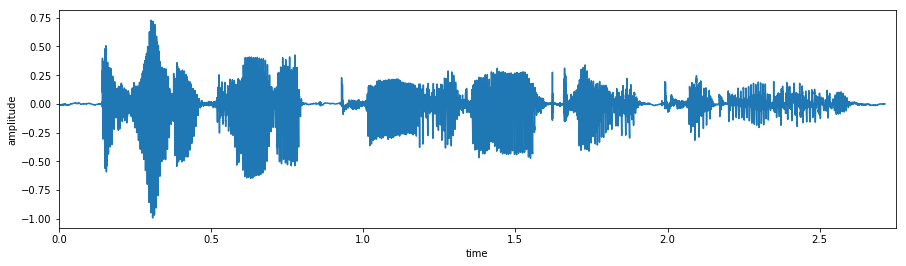

In [37]:
y, sr = librosa.load(wavs[0])

y = librosa.resample(y, sr, 8000)

sr=8000

time = [x/sr for x in range(0, len(y))]
plt.figure(figsize=(15, 4))
plt.plot(time,y)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.xlim(0, 2.75)

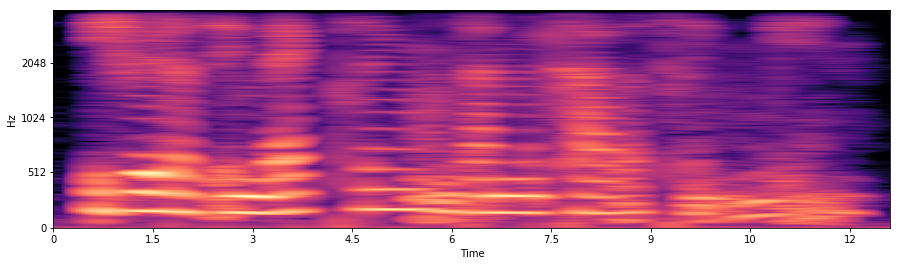

In [81]:
hop_length=int(0.005*sr)
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13, dct_type=2)

S = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, n_mels=256, fmax=4000)
plt.figure(figsize=(15, 4))
librosa.display.specshow(librosa.power_to_db((S),ref=np.max), y_axis='mel', fmax=4000, x_axis='time')

In [7]:
# train feature extraction
all_emotions=glob.glob('/home/kalam/Workspace/ML/Learning/EMODB/traindata/*')

window_overlap = 0.005
n_mixtures = 16
max_iterations = 200
calc_deltas=True

import os
from sklearn import mixture
from sklearn.externals import joblib

directory='/home/kalam/Workspace/ML/Learning/feat/train/'
if not os.path.exists(directory):
    os.makedirs(directory)
    
directory='/home/kalam/Workspace/ML/Learning/train_models/'
if not os.path.exists(directory):
    os.makedirs(directory)

    
for itr1 in range(0,len(all_emotions)):
    
    wavs=glob.glob(all_emotions[itr1]+'/*.wav')
    
    emotion=(all_emotions[itr1]).split("/")[-1]
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    final_feat=np.empty([0, 39])
    
    for itr2 in range(0,len(wavs)):
        
        y, sr = librosa.load(wavs[itr2])
        y = librosa.resample(y, sr, 8000)
        sr=8000
        
        hop_length=int(0.01*sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_ddelta = librosa.feature.delta(mfcc_delta)
        feat=np.concatenate((mfcc,mfcc_delta,mfcc_ddelta),axis=0)
        feat=feat.transpose()
        
        final_feat=np.concatenate((final_feat,feat),axis=0)
        

        #print(final_feat.shape)
    print(emotion)    
    np.savetxt('/home/kalam/Workspace/ML/Learning/feat/train/'+emotion+"_all_features.txt", final_feat, delimiter=",")

    try:
        gmm = mixture.GaussianMixture(n_components=n_mixtures, covariance_type='diag' , max_iter = max_iterations ).fit(final_feat)
    except:
        print("ERROR : Error while training model for file "+emotion)
        
    try:
        joblib.dump(gmm,'train_models/'+emotion+'.pkl')
    except:
        print("ERROR : Error while saving model for "+emotion)
        

print("Training Completed")    

neutral
sad
anger
happy
Training Completed


In [8]:
# train feature extraction
all_emotions=glob.glob('/home/kalam/Workspace/ML/Learning/EMODB/testdata/*')

import os
directory='/home/kalam/Workspace/ML/Learning/feat/test/'
if not os.path.exists(directory):
    os.makedirs(directory)

emotions = { all_emotions[k]:k for k in range(len(all_emotions)) }

num_test_cases={}
tct={}
for e in emotions:
    num_test_cases[e.replace('/home/kalam/Workspace/ML/Learning/EMODB/testdata/','')]=len(os.listdir(e))-1
    tct[e.replace('/home/kalam/Workspace/ML/Learning/EMODB/testdata/','')]=0

print(num_test_cases)

emotion_names = { all_emotions[k].replace('/home/kalam/Workspace/ML/Learning/EMODB/testdata/',''):k for k in range(len(all_emotions)) }

total_emotions=len(num_test_cases)

confusion_matrix = np.zeros((total_emotions,total_emotions))


for itr1 in range(0,len(all_emotions)):
    
    wavs=glob.glob(all_emotions[itr1]+'/*.wav')
    
    emotion=(all_emotions[itr1]).split("/")[-1]
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    final_feat=np.empty([0, 39])
    
    for itr2 in range(0,len(wavs)):
        #print(wavs[itr2])
        
        y, sr = librosa.load(wavs[itr2])
        y = librosa.resample(y, sr, 8000)
        sr=8000

        mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_ddelta = librosa.feature.delta(mfcc_delta)
        feat=np.concatenate((mfcc,mfcc_delta,mfcc_ddelta),axis=0)
        feat=feat.transpose()
        
        final_feat=np.concatenate((final_feat,feat),axis=0)

        #print(final_feat.shape)
        max_score=-np.inf
        max_emotion_name=""
        
        for modelfile in sorted(glob.glob('train_models/*.pkl')):
            gmm = joblib.load(modelfile) 
            score=gmm.score(feat)
            #print score
            if score>max_score:
                max_score,max_emotion_name=score,modelfile.replace('train_models/','').replace('.pkl','')

        print(emotion+" -> "+max_emotion_name+(" Y" if emotion==max_emotion_name  else " N"))

        confusion_matrix[ emotion_names[emotion] ][emotion_names[max_emotion_name]]+=1
        tct[emotion]+=1

        
    #print(emotion)
    np.savetxt('/home/kalam/Workspace/ML/Learning/feat/test/'+emotion+"_all_features.txt", feat, delimiter=",")

    

{'neutral': 20, 'sad': 19, 'anger': 25, 'happy': 17}
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
neutral -> neutral Y
sad -> sad Y
sad -> neutral N
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> neutral N
sad -> sad Y
sad -> sad Y
sad -> neutral N
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> sad Y
sad -> sad Y
anger -> anger Y
anger -> anger Y
anger -> happy N
anger -> anger Y
anger -> happy N
anger -> happy N
anger -> anger Y
anger -> anger Y
anger -> anger Y
anger -> anger Y
anger -> anger Y
anger -> anger Y
anger -> happy N
anger -> ange

In [9]:
print(tct)
print("Confusion Matrix:\n",confusion_matrix)
print("Accuracy: ",(sum([ confusion_matrix[i][j] if i==j  else 0 for i in range(total_emotions) for j in range(total_emotions) ] )*100)/float(sum([i for i in tct.values()])))

{'neutral': 21, 'sad': 20, 'anger': 26, 'happy': 18}
Confusion Matrix:
 [[21.  0.  0.  0.]
 [ 3. 17.  0.  0.]
 [ 0.  0. 20.  6.]
 [ 1.  0.  0. 17.]]
Accuracy:  88.23529411764706
